In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [2]:
with open("census-bureau.columns") as f:
    columns = [line.strip() for line in f]

In [3]:
df = pd.read_csv(
    "census-bureau.data",
    header=None,
    names=columns
)

# Dataset Overview

In [4]:
print(df.shape)

(199523, 42)


In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  str    
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  str    
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  str    
 7   marital stat                                199523 non-null  str    
 8   major industry code                         199523 non-null  str    
 9   major occupation code                       199523 non-null  str    
 10  race   

In [6]:
df.describe()

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


# Missing Values
The column "hispanic origin" is the only variable containing null values, which are imputed as "Unknown" since they represent unspecified ethnicity.

Several migration-related variables contain the value "?" in a large proportion of observations (approximately 50%), indicating not applicable rather than missing data. These values are replaced with "Not applicable".

For the country-of-birth variables (father, mother, self), the value "?" appears infrequently and is treated as unknown information. These entries are replaced with "Unknown" to ensure consistent categorical encoding.

In [7]:
df.isna().sum().sort_values(ascending=False)

hispanic origin                               874
age                                             0
weight                                          0
migration code-change in msa                    0
migration code-change in reg                    0
migration code-move within reg                  0
live in this house 1 year ago                   0
migration prev res in sunbelt                   0
num persons worked for employer                 0
family members under 18                         0
country of birth father                         0
detailed household and family stat              0
country of birth mother                         0
country of birth self                           0
citizenship                                     0
own business or self employed                   0
fill inc questionnaire for veteran's admin      0
veterans benefits                               0
weeks worked in year                            0
year                                            0


In [8]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct[missing_pct > 0]

hispanic origin    0.438045
dtype: float64

In [9]:
cols_check = [
    "hispanic origin",
    "migration code-change in msa",
    "migration code-change in reg",
    "migration code-move within reg",
    "migration prev res in sunbelt",
    "country of birth father",
    "country of birth mother",
    "country of birth self"
]

for col in cols_check:
    null_pct = df[col].isna().mean() * 100
    q_pct = (df[col] == "?").mean() * 100
    print(f"{col}: null={null_pct:.2f}%, '?'={q_pct:.2f}%")

hispanic origin: null=0.44%, '?'=0.00%
migration code-change in msa: null=0.00%, '?'=49.97%
migration code-change in reg: null=0.00%, '?'=49.97%
migration code-move within reg: null=0.00%, '?'=49.97%
migration prev res in sunbelt: null=0.00%, '?'=49.97%
country of birth father: null=0.00%, '?'=3.36%
country of birth mother: null=0.00%, '?'=3.07%
country of birth self: null=0.00%, '?'=1.70%


In [10]:
# hispanic origin
df["hispanic origin"] = df["hispanic origin"].fillna("Unknown")

# migration columns
for col in [
    "migration code-change in msa",
    "migration code-change in reg",
    "migration code-move within reg",
    "migration prev res in sunbelt"
]:
    df[col] = df[col].replace("?", "Not applicable")

# country columns
for col in [
    "country of birth father",
    "country of birth mother",
    "country of birth self"
]:
    df[col] = df[col].replace("?", "Unknown")

# Duplicate Rows
Duplicate records were not removed because identical demographic profiles can legitimately appear multiple times in population census data.

In [21]:
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 3229


# Target Distribution
The target variable in this dataset is highly imbalanced. Income greater than $50,000 is labeled as 1, while income less than or equal to $50,000 is labeled as 0, with the majority of observations belonging to the lower-income group.

In [19]:
income_dist = (
    df["label"]
    .value_counts(normalize=True)
    .rename("percentage(%)")
    .reset_index()
    .rename(columns={"label": "income"})
)
income_dist["percentage(%)"] = (income_dist["percentage(%)"] * 100).round(2)
income_dist

,income,percentage(%)
0,- 50000.,93.79
1,50000+.,6.21


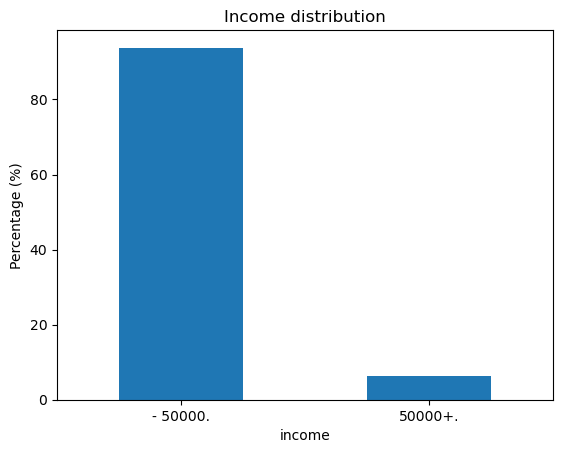

In [20]:
income_dist.plot(
    x="income",
    y="percentage(%)",
    kind="bar",
    legend=False
)

plt.ylabel("Percentage (%)")
plt.title("Income distribution")
plt.xticks(rotation=0)
plt.show()

In [ ]:
df["income_binary"] = df["label"].map({
    "- 50000.": 0,
    "50000+.": 1
})

# Numeric Variables: EDA and Preprocessing

The distribution of numeric variables and their relationship with the target variable (`income_binary`) were examined. Based on distributional characteristics and variable meaning, the following preprocessing decisions were made.

**Age, num persons worked for employer, and weeks worked in year:**  
These variables are meaningful numeric indicators of income (with relatively high effect sizes) and are kept as numeric features.

**Detailed industry recode and detailed occupation recode:**  
These are detailed numeric recodes corresponding to major industry and occupation categories. They are excluded from modeling to avoid redundancy and potential multicollinearity.

**Wage per hour, capital gains, capital losses, and dividends from stocks:**  
These variables are strongly right-skewed with many zero values. Log transformation is applied to reduce skewness. Binary indicators are also created for capital income variables to capture whether capital income exists.

**Weight:**  
The `weight` variable represents sampling weight rather than individual characteristics and is excluded from model features.

**Own business or self employed, veterans benefits, and year:**  
These variables are categorical in nature without ordinal meaning and are converted to categorical features.

In [79]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("income_binary")
print(num_cols)

Index(['age', 'detailed industry recode', 'detailed occupation recode',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'weight', 'num persons worked for employer',
       'own business or self employed', 'veterans benefits',
       'weeks worked in year', 'year', 'has_capital_gains',
       'log_capital_gains', 'has_capital_losses', 'log_capital_losses',
       'log_wage_per_hour', 'has_dividends_from_stocks',
       'log_dividends_from_stocks'],
      dtype='str')


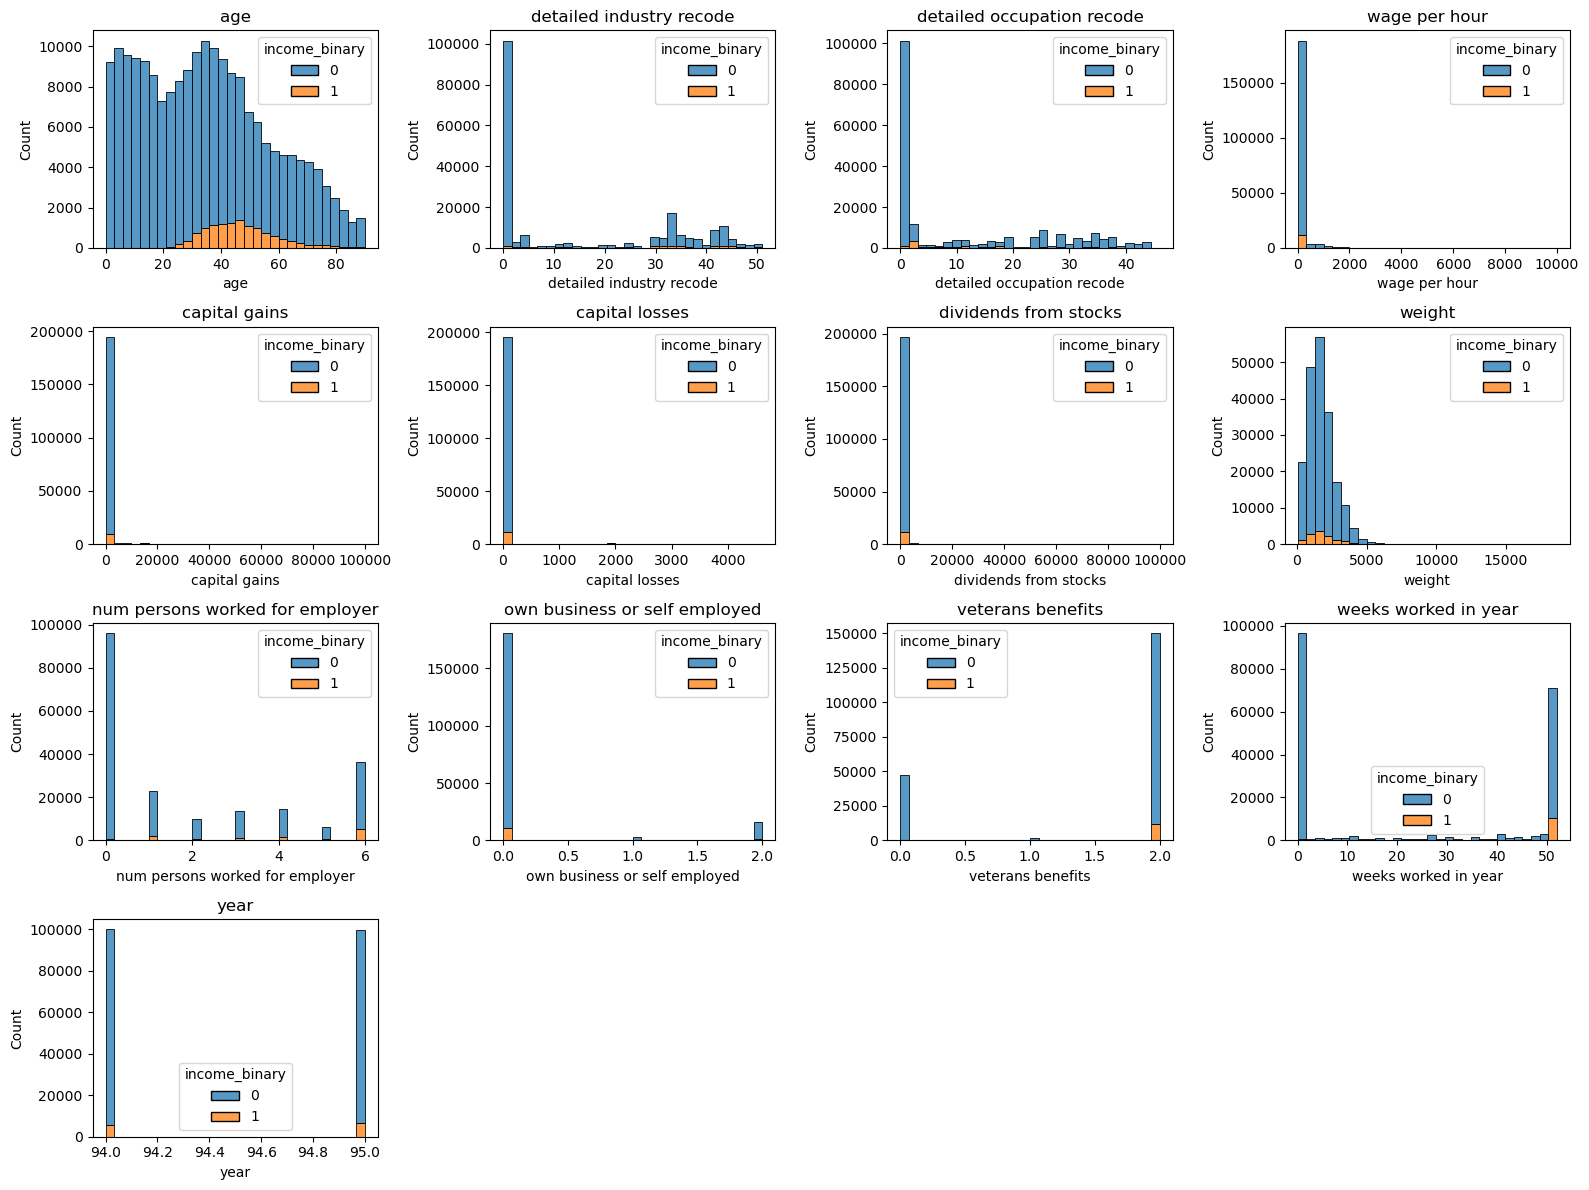

In [55]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)

    sns.histplot(
        data=df,
        x=col,
        bins=30,
        hue="income_binary",
        multiple="stack"
    )

    plt.title(col)

plt.tight_layout()
plt.show()

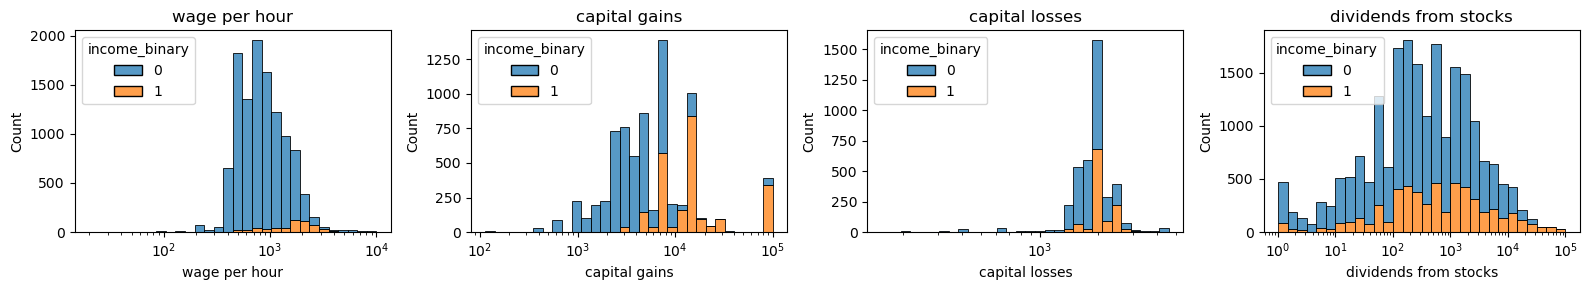

In [70]:
log_cols = [
    "wage per hour",
    "capital gains",
    "capital losses",
    "dividends from stocks"
]

plt.figure(figsize=(16, 3))

for i, col in enumerate(log_cols):
    plt.subplot(1, 4, i + 1)

    sns.histplot(
        data=df,
        x=col,
        bins=30,
        log_scale=True,
        hue="income_binary",
        multiple="stack"
    )

    plt.title(col)

plt.tight_layout()
plt.show()

In [71]:
# log transform
df["log_wage_per_hour"] = np.log1p(df["wage per hour"])

df["has_capital_gains"] = (df["capital gains"] > 0).astype(int)
df["log_capital_gains"] = np.log1p(df["capital gains"])

df["has_capital_losses"] = (df["capital losses"] > 0).astype(int)
df["log_capital_losses"] = np.log1p(df["capital losses"])

df["has_dividends_from_stocks"] = (df["dividends from stocks"] > 0).astype(int)
df["log_dividends_from_stocks"] = np.log1p(df["dividends from stocks"])

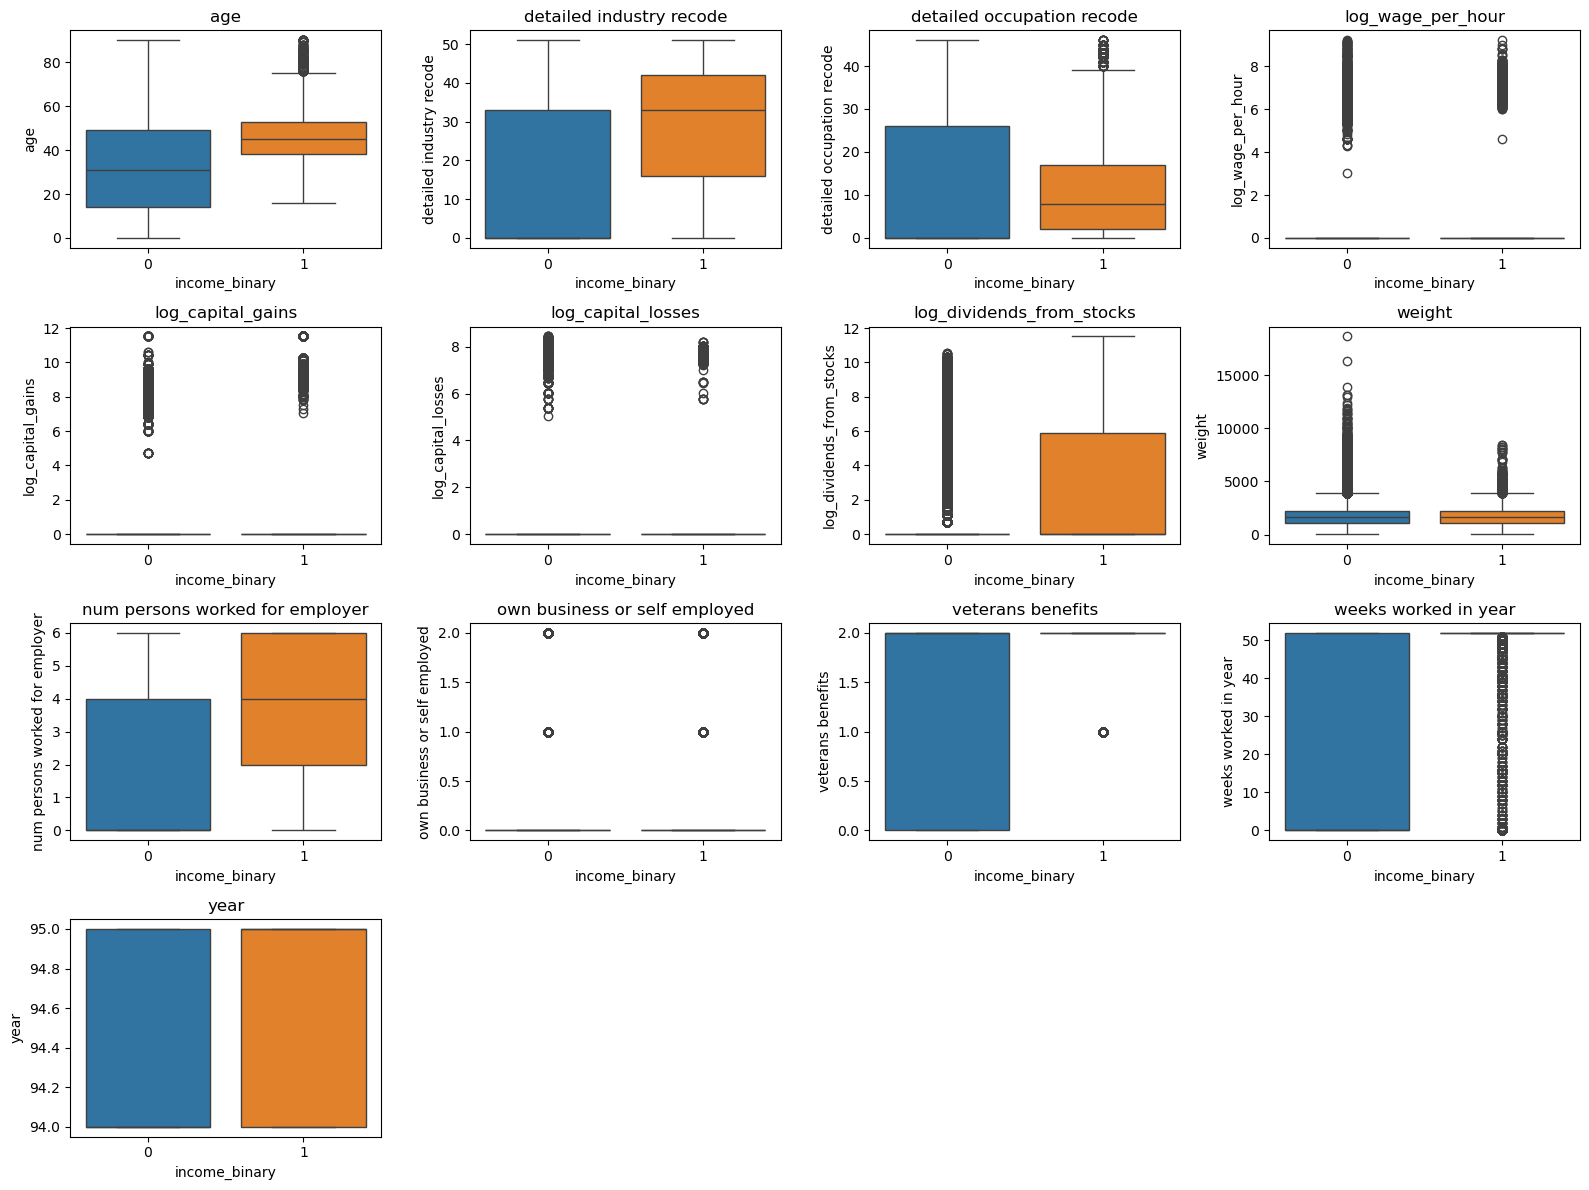

In [72]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)

    if col in log_cols:
        plot_col = "log_" + col.replace(" ", "_")
    else:
        plot_col = col

    ax = sns.boxplot(
        data=df,
        x="income_binary",
        y=plot_col,
        hue="income_binary"
    )

    # remove legend
    if ax.legend_:
        ax.legend_.remove()

    plt.title(plot_col)

plt.tight_layout()
plt.show()

In [73]:
ttest_cols = [
    "age",
    "log_wage_per_hour",
    "log_capital_gains",
    "log_capital_losses",
    "log_dividends_from_stocks",
    "num persons worked for employer",
    "weeks worked in year"
]

ttest_results = []

for col in ttest_cols:
    g0 = df[df["income_binary"] == 0][col]
    g1 = df[df["income_binary"] == 1][col]

    stat, p = ttest_ind(g0, g1, equal_var=False)
    ttest_results.append([col, stat, p])

pd.DataFrame(ttest_results, columns=["feature", "t_stat", "p_value"])

,feature,t_stat,p_value
0,age,-105.928686,0.000000e+00
1,log_wage_per_hour,3.840501,1.233190e-04
2,log_capital_gains,-47.919433,0.000000e+00
3,log_capital_losses,-30.277807,1.776450e-194
4,log_dividends_from_stocks,-72.147220,0.000000e+00
5,num persons worked for employer,-110.391144,0.000000e+00
6,weeks worked in year,-214.955555,0.000000e+00


In [74]:
mean_table = (
    df.groupby("income_binary")[ttest_cols]
      .mean()
      .T
)

mean_table.columns = ["income_0_mean", "income_1_mean"]
mean_table["difference"] = mean_table["income_1_mean"] - mean_table["income_0_mean"]

mean_table

,income_0_mean,income_1_mean,difference
age,33.715316,46.266193,12.550877
log_wage_per_hour,0.385386,0.330778,-0.054607
log_capital_gains,0.217843,1.873890,1.656047
log_capital_losses,0.109416,0.718129,0.608713
log_dividends_from_stocks,0.466807,2.693010,2.226203
num persons worked for employer,1.820707,4.003715,2.183008
weeks worked in year,21.527762,48.069617,26.541855


In [75]:
effect_size = []

for col in ttest_cols:
    g0 = df[df["income_binary"] == 0][col]
    g1 = df[df["income_binary"] == 1][col]

    mean0 = g0.mean()
    mean1 = g1.mean()

    std0 = g0.std()
    std1 = g1.std()

    pooled_std = np.sqrt((std0**2 + std1**2) / 2)
    d = (mean1 - mean0) / pooled_std

    effect_size.append([col, mean0, mean1, d])

effect_df = pd.DataFrame(
    effect_size,
    columns=["feature", "income_0_mean", "income_1_mean", "cohens_d"]
)

effect_df.sort_values("cohens_d", ascending=False)

,feature,income_0_mean,income_1_mean,cohens_d
6,weeks worked in year,21.527762,48.069617,1.387383
5,num persons worked for employer,1.820707,4.003715,0.983274
4,log_dividends_from_stocks,0.466807,2.693010,0.831890
0,age,33.715316,46.266193,0.695318
2,log_capital_gains,0.217843,1.873890,0.577808
3,log_capital_losses,0.109416,0.718129,0.358714
1,log_wage_per_hour,0.385386,0.330778,-0.035276


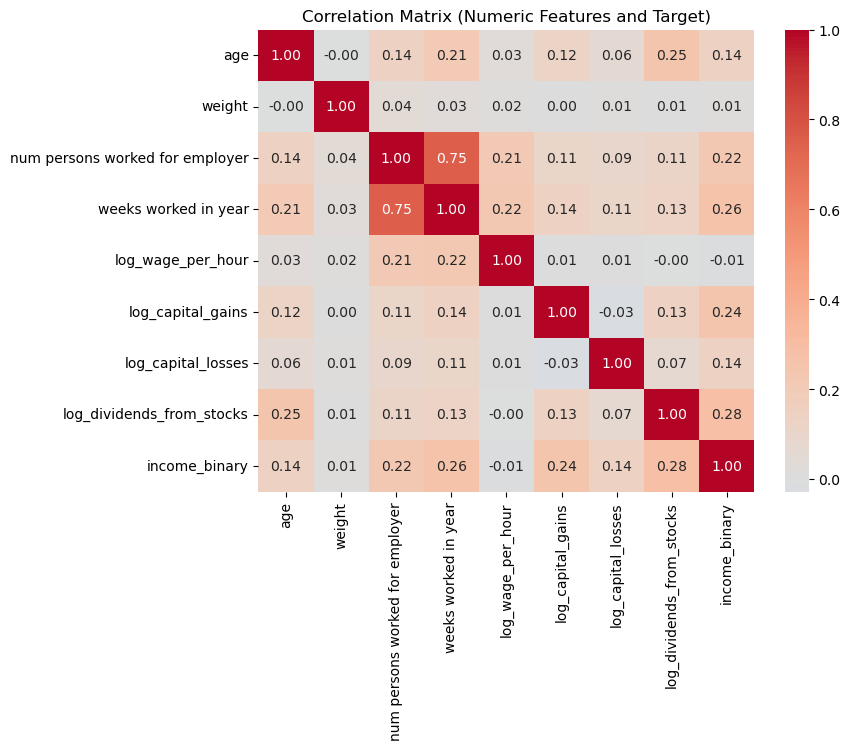

In [146]:
corr_cols = [
    "age",
    "weight",
    "num persons worked for employer",
    "weeks worked in year",
    "log_wage_per_hour",
    "log_capital_gains",
    "log_capital_losses",
    "log_dividends_from_stocks",
    "income_binary"
]

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)

plt.title("Correlation Matrix (Numeric Features and Target)")
plt.show()

# Categoric Variables: EDA and Preprocessing

In [81]:
numtocat_cols = [
    "own business or self employed",
    "veterans benefits",
    "year"
]

for col in numtocat_cols:
    df[col] = df[col].astype("category")

In [83]:
cat_cols = df.select_dtypes(include=["str"]).columns.drop("label")
print(cat_cols)

for col in cat_cols:
    df[col] = df[col].astype("category")

Index(['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', 'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother',
       'country of birth self', 'citizenship',
       'fill inc questionnaire for veteran's admin'],
      dtype='str')


In [85]:
cat_cols = df.select_dtypes(include=["category"]).columns
print(cat_cols)

Index(['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', 'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother',
       'country of birth self', 'citizenship', 'own business or self employed',
       'fill inc questionnaire for veteran's admin', 'veterans benefits',
       'year'],
      dtype='str')


In [91]:
pd.DataFrame({
    "feature": cat_cols,
    "nunique": [df[col].nunique() for col in cat_cols]
}).sort_values("nunique", ascending=False)

,feature,nunique
14,state of previous residence,51
25,country of birth self,43
24,country of birth mother,43
23,country of birth father,43
15,detailed household and family stat,38
4,major industry code,24
1,education,17
5,major occupation code,15
7,hispanic origin,10
19,migration code-move within reg,10


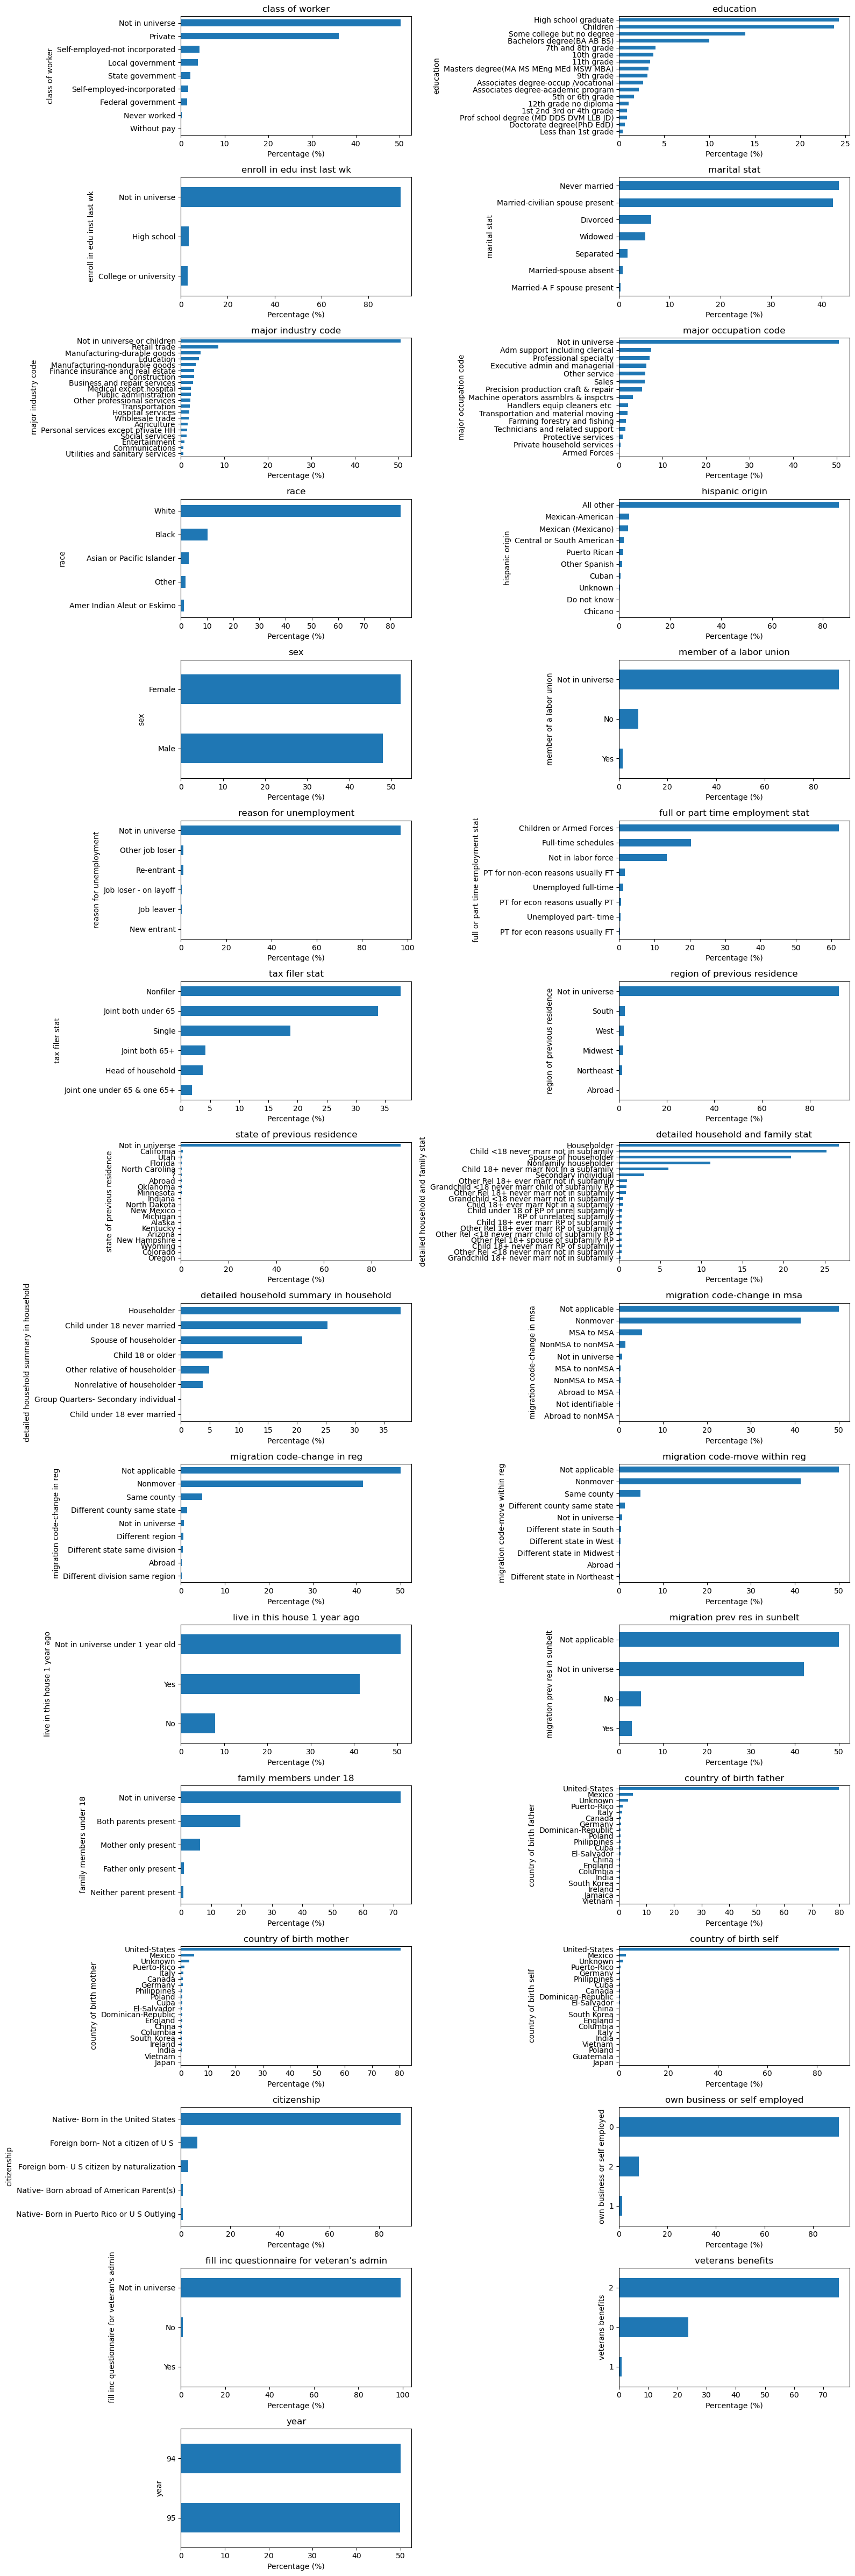

In [94]:
n_cols = len(cat_cols)
n_rows = math.ceil(n_cols / 2)

plt.figure(figsize=(16, 3 * n_rows))

for i, col in enumerate(cat_cols):
    plt.subplot(n_rows, 2, i + 1)

    (
        df[col]
        .value_counts(normalize=True)
        .head(20)
        .sort_values()
        .mul(100)
        .plot(kind="barh")
    )

    plt.xlabel("Percentage (%)")
    plt.title(col)

plt.tight_layout()
plt.show()

In [114]:
chi2_results = []

for col in cat_cols:
    ct = pd.crosstab(df[col], df["income_binary"])
    chi2, p, dof, expected = chi2_contingency(ct)
    chi2_results.append((col, p))

pd.DataFrame(chi2_results, columns=["feature", "p_value"]).sort_values("p_value")

,feature,p_value
0,class of worker,0.000000e+00
22,family members under 18,0.000000e+00
16,detailed household summary in household,0.000000e+00
29,veterans benefits,0.000000e+00
12,tax filer stat,0.000000e+00
11,full or part time employment stat,0.000000e+00
8,sex,0.000000e+00
15,detailed household and family stat,0.000000e+00
5,major occupation code,0.000000e+00
4,major industry code,0.000000e+00


In [115]:
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    chi2 = chi2_contingency(ct)[0]
    n = ct.sum().sum()
    k = min(ct.shape) - 1
    return np.sqrt(chi2 / (n * k))

results = []

for col in cat_cols:
    try:
        v = cramers_v(df[col], df["income_binary"])
        results.append((col, v))
    except:
        pass

effect_df = pd.DataFrame(results, columns=["feature", "cramers_v"])
effect_df.sort_values("cramers_v", ascending=False)

,feature,cramers_v
1,education,0.389837
5,major occupation code,0.366264
4,major industry code,0.277860
0,class of worker,0.260531
15,detailed household and family stat,0.240458
12,tax filer stat,0.229232
16,detailed household summary in household,0.227220
3,marital stat,0.197655
11,full or part time employment stat,0.159847
22,family members under 18,0.159167


In [116]:
variation_results = []

for col in cat_cols:
    rates = pd.crosstab(
        df[col],
        df["income_binary"],
        normalize="index"
    )[1]
    
    variation = rates.max() - rates.min()
    variation_results.append((col, variation))

variation_df = pd.DataFrame(
    variation_results,
    columns=["feature", "income_rate_range"]
).sort_values("income_rate_range", ascending=False)

variation_df

,feature,income_rate_range
1,education,0.540435
0,class of worker,0.342764
5,major occupation code,0.284991
4,major industry code,0.254034
25,country of birth self,0.217391
27,own business or self employed,0.167872
15,detailed household and family stat,0.147423
24,country of birth mother,0.142857
23,country of birth father,0.137255
12,tax filer stat,0.130917


In [122]:
imp_cat_cols = [
    "education",
    "major occupation code",
    "major industry code",
    "class of worker",
    "marital stat",
    "detailed household summary in household",
    "sex",
    "race"
]

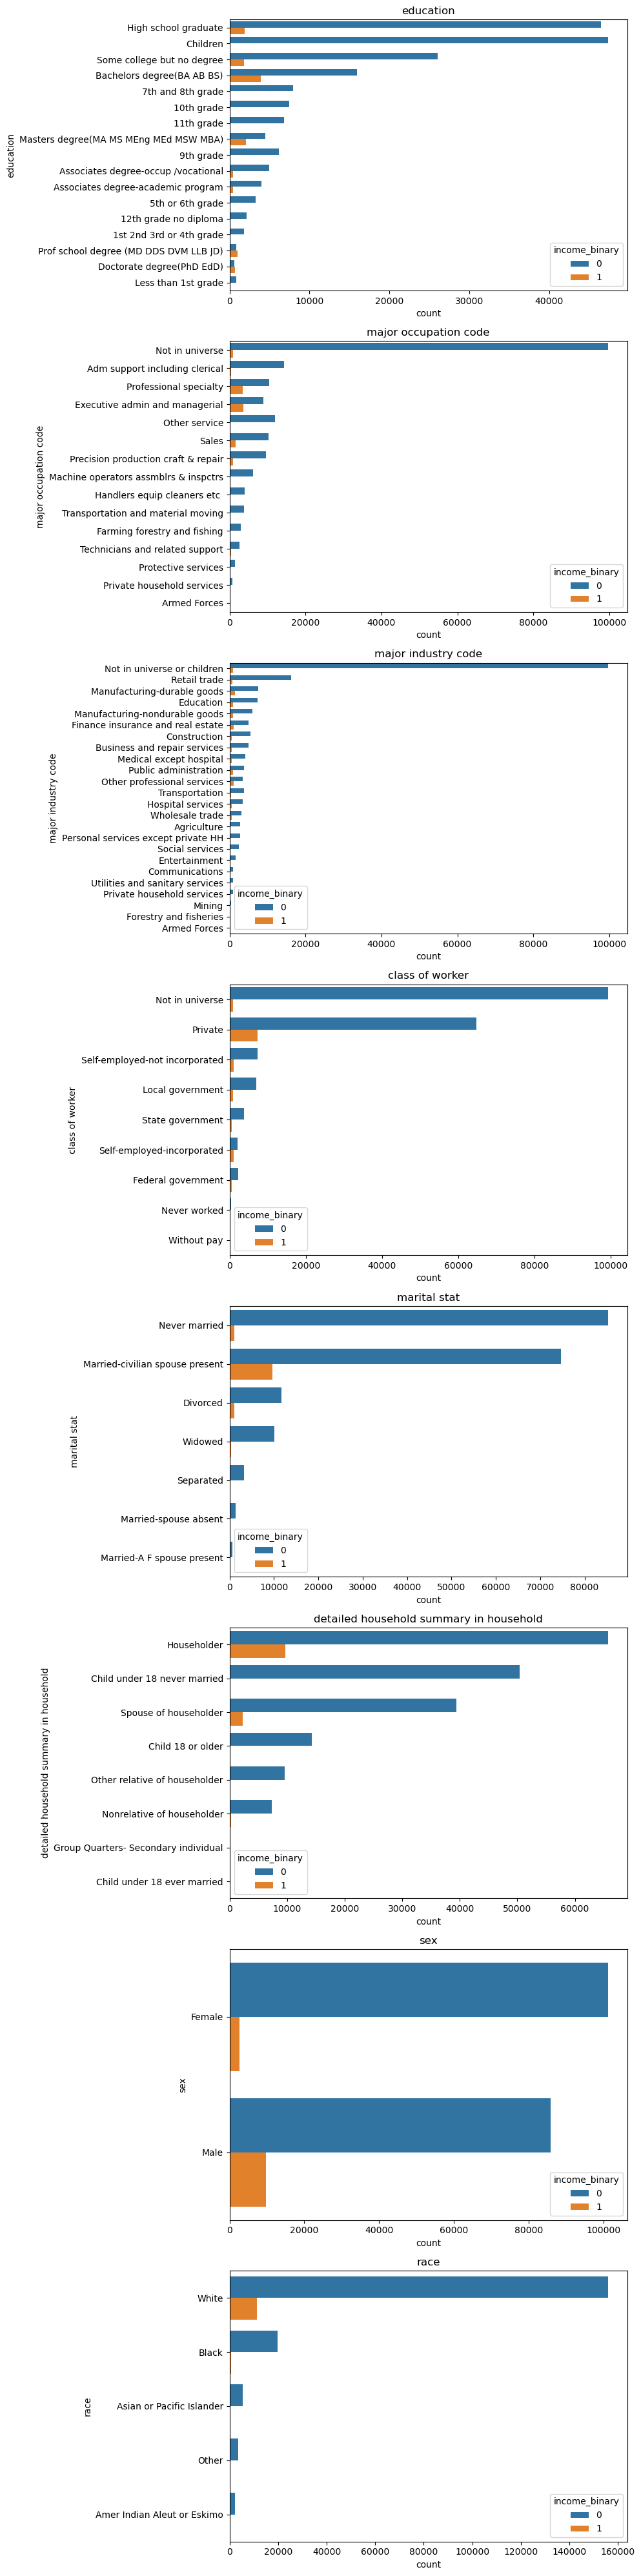

In [123]:
n_rows = len(imp_cat_cols)

plt.figure(figsize=(10, 5 * n_rows))

for i, col in enumerate(imp_cat_cols):
    plt.subplot(n_rows, 1, i + 1)

    order = df[col].value_counts().index

    sns.countplot(
        data=df,
        y=col,
        hue="income_binary",
        order=order
    )

    plt.title(col)

plt.tight_layout()
plt.show()

In [131]:
for col in imp_cat_cols:
    print(f"\n===== {col} =====")

    ct = (
        pd.crosstab(df[col], df["income_binary"], normalize="index") * 100
    ).round(2)

    ct = ct.rename(columns={0: "income_0_%", 1: "income_1_%"})

    top10 = ct.sort_values("income_1_%", ascending=False).head(10)

    display(top10)


===== education =====


income_binary,income_0_%,income_1_%
education,,
Prof school degree (MD DDS DVM LLB JD),45.96,54.04
Doctorate degree(PhD EdD),47.98,52.02
Masters degree(MA MS MEng MEd MSW MBA),68.84,31.16
Bachelors degree(BA AB BS),80.29,19.71
Associates degree-academic program,90.56,9.44
Associates degree-occup /vocational,92.29,7.71
Some college but no degree,93.58,6.42
High school graduate,96.12,3.88
12th grade no diploma,98.40,1.60



===== major occupation code =====


income_binary,income_0_%,income_1_%
major occupation code,,
Executive admin and managerial,71.24,28.76
Professional specialty,75.07,24.93
Armed Forces,77.78,22.22
Protective services,84.41,15.59
Sales,87.07,12.93
Technicians and related support,88.04,11.96
Precision production craft & repair,90.92,9.08
Transportation and material moving,93.56,6.44
Farming forestry and fishing,94.91,5.09



===== major industry code =====


income_binary,income_0_%,income_1_%
major industry code,,
Mining,74.07,25.93
Other professional services,76.71,23.29
Communications,77.14,22.86
Armed Forces,77.78,22.22
Utilities and sanitary services,78.27,21.73
Finance insurance and real estate,81.79,18.21
Public administration,82.06,17.94
Manufacturing-durable goods,83.43,16.57
Wholesale trade,84.65,15.35



===== class of worker =====


income_binary,income_0_%,income_1_%
class of worker,,
Self-employed-incorporated,65.27,34.73
Federal government,79.59,20.41
Self-employed-not incorporated,87.09,12.91
State government,88.53,11.47
Local government,89.12,10.88
Private,89.83,10.17
Not in universe,99.10,0.90
Without pay,99.39,0.61
Never worked,99.54,0.46



===== marital stat =====


income_binary,income_0_%,income_1_%
marital stat,,
Married-civilian spouse present,88.60,11.40
Divorced,91.61,8.39
Married-spouse absent,93.68,6.32
Separated,95.43,4.57
Widowed,96.85,3.15
Married-A F spouse present,97.74,2.26
Never married,98.71,1.29



===== detailed household summary in household =====


income_binary,income_0_%,income_1_%
detailed household summary in household,,
Householder,87.21,12.79
Spouse of householder,94.53,5.47
Nonrelative of householder,96.92,3.08
Other relative of householder,99.11,0.89
Child 18 or older,99.13,0.87
Group Quarters- Secondary individual,99.24,0.76
Child under 18 ever married,100.00,0.00
Child under 18 never married,100.00,0.00



===== sex =====


income_binary,income_0_%,income_1_%
sex,,
Male,89.83,10.17
Female,97.44,2.56



===== race =====


income_binary,income_0_%,income_1_%
race,,
Asian or Pacific Islander,92.63,7.37
White,93.27,6.73
Black,97.35,2.65
Other,97.51,2.49
Amer Indian Aleut or Eskimo,97.82,2.18


In [137]:
# identify redundant features
cols = [
    "state of previous residence",
    "region of previous residence"
]

mat = pd.DataFrame(index=cols, columns=cols)

for c1 in cols:
    for c2 in cols:
        mat.loc[c1, c2] = cramers_v(df[c1], df[c2])

mat

,state of previous residence,region of previous residence
state of previous residence,1.0,0.966115
region of previous residence,0.966115,1.0


In [138]:
cols = [
    "detailed household and family stat",
    "detailed household summary in household"
]

mat = pd.DataFrame(index=cols, columns=cols)

for c1 in cols:
    for c2 in cols:
        mat.loc[c1, c2] = cramers_v(df[c1], df[c2])

mat

,detailed household and family stat,detailed household summary in household
detailed household and family stat,1.0,0.976203
detailed household summary in household,0.976203,1.0


In [139]:
cols = [
    "migration code-change in msa",
    "migration code-change in reg",
    "migration code-move within reg",
    "live in this house 1 year ago",
    "migration prev res in sunbelt"
]

mat = pd.DataFrame(index=cols, columns=cols)

for c1 in cols:
    for c2 in cols:
        mat.loc[c1, c2] = cramers_v(df[c1], df[c2])

mat


,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt
migration code-change in msa,1.0,0.722504,0.681812,1.0,0.823663
migration code-change in reg,0.722504,1.0,0.868637,1.0,0.82153
migration code-move within reg,0.681812,0.868637,1.0,1.0,0.837272
live in this house 1 year ago,1.0,1.0,1.0,1.0,0.99178
migration prev res in sunbelt,0.823663,0.82153,0.837272,0.99178,1.0


In [140]:
cat_cols

Index(['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', 'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother',
       'country of birth self', 'citizenship', 'own business or self employed',
       'fill inc questionnaire for veteran's admin', 'veterans benefits',
       'year'],
      dtype='str')

In [142]:
# rare category grouping
rare_cols = [
    "major industry code",
    "major occupation code",
    "country of birth father",
    "country of birth mother",
    "country of birth self"
]

for col in rare_cols:
    freq = df[col].value_counts(normalize=True)
    rare_levels = freq[freq < 0.01].index

    new_col = "merge_" + col

    df[new_col] = df[col].astype(str)
    df.loc[df[new_col].isin(rare_levels), new_col] = "Other"
    df[new_col] = df[new_col].astype("category")

In [150]:
df.columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'ow

In [151]:
df.to_pickle("cleaned_df.pkl")